# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [ ]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [ ]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

In [ ]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [ ]:
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [ ]:
data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

In [ ]:
df_processed = df_combined.copy()
df_processed['Length'] = 0
df_processed['Language']=pd.NA
df_processed['Title_Processed']=pd.NA
df_processed['Title_Translated']=pd.NA
df_processed['Title_Cleaned']=pd.NA
print(df_processed.info())
df_processed.head()

# Cleanup Product Name

In [ ]:
hist_by_labels(df_processed, 'Product Name', log=True, horizontal=True)

In [ ]:
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'
df_processed.loc[df_processed['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_processed['Module Name']
df_processed.drop(columns=['Module Name'], inplace=True)
df_processed.dropna(subset=['Product Name'], inplace=True)

# Consolidate the following products into Petrel
df_processed.loc[df_processed['Product Name'] == 'Petrel Exploration Geology', 'Product Name'] = 'Petrel'
df_processed.loc[df_processed['Product Name'] == 'Petrel Project Explorer', 'Product Name'] = 'Petrel'

# Case of one product has multiple names
df_processed.loc[df_processed['Product Name'] == 'DELFI RE', 'Product Name'] = 'Petrel RE' # Pretel RE --> DELFI RE
df_processed.loc[df_processed['Product Name'] == 'OMEGA', 'Product Name'] = 'Omega' # OMEGA --> Omega
df_processed.loc[df_processed['Product Name'] == 'Other', 'Product Name'] = 'Others' # Other --> Others
df_processed.loc[df_processed['Product Name'] == 'Third-Party Applications', 'Product Name'] = 'App – Third Party' # Third-Party Applications --> App – Third Party
df_processed.loc[df_processed['Product Name'] == 'Ocean Plug-ins for Petrel - Third party', 'Product Name'] = 'Ocean Plug-ins for Petrel - Third Party' # Ocean Plug-ins for Petrel - Third party --> Ocean Plug-ins for Petrel - Third Party

# Consolidate the following products into 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Provisioning & Decommissioning', 'Product Name'] = 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Software Demo and Evaluation', 'Product Name'] = 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Internal Deployment', 'Product Name'] = 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Image', 'Product Name'] = 'Deployment'

# Consolidate the following products into 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'SAuth', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'License', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'Licensing', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'Environment', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'Authorization', 'Product Name'] = 'Delfi Portal'

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_processed = df_processed[df_processed['Product Name'] != 'Quality and Feedback']
df_processed = df_processed[df_processed['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_processed = df_processed.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_processed.info())
hist_by_labels(df_processed, 'Product Name', top=None, log=True, horizontal=True)

# Clean-up Title Column

## Quick Clean-up

In [ ]:
# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = len(processed_title)
#     df.at[index, 'Language'] = detect_language_fasttext(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

In [ ]:
# Delete records with missing values in 'ProductName' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

In [ ]:
# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()


In [ ]:
# fasttext performance is better than the other solutions for short text 
# (ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)
hist_by_labels(df_processed, "Language", top=20, log=True, horizontal=True)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'

# Export the DataFrame to Excel
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Language Detection

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
df_processed = pd.read_excel(excel_file)

df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']
print(df_translated.info())
df_translated.head(-10)

In [ ]:
# Keep the top 10 languages and drop the rest and the unknown. 
# why? There are high chances the detected language were not correct due to wrong spelling, etc.

language_counts = df_translated['Language'].value_counts()
cutoff = 99
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_translated['Language'].isin(language_others)
df_translated.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_translated = df_translated[df_translated['Language'] != 'unknown']
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

## Translation of Non-English

In [ ]:
# Group the DataFrame by the "Language" column
grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [{lang}/{len(group)}]")

    translated_titles = translate_array(
        group["Title_Translated"].tolist(),
        src_lang=lang,
        tar_lang='en',
        length_limit=1250)
    group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

In [ ]:
print(df_translated.isnull().sum().sort_values(ascending = False))

# Delete records with missing values in 'ProductName' columns
df_translated.dropna(subset=['Title_Translated'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_translated.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'

# Export the DataFrame to Excel
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Data Augmentation

In [24]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'

df_argumented = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())
print(df_cleaned.info())
df_cleaned.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115663 entries, 0 to 115662
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        115663 non-null  int64 
 1   Title             115663 non-null  object
 2   Product Name      115663 non-null  object
 3   Length            115663 non-null  int64 
 4   Language          115663 non-null  object
 5   Title_Processed   115663 non-null  object
 6   Title_Translated  115663 non-null  object
 7   Title_Cleaned     115663 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115663 entries, 0 to 115662
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        115663 non-null  int64 
 1   Title             115663 non-null  object
 2   Product Name      115663 non-null  object
 3   Length         

,Request ID,Title,Product Name,Length,Language,Title_Processed,Title_Translated,Title_Cleaned
0,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,6,en,SH PED Patch Log for pro Source,SH PED Patch Log for pro Source,sh ped patch log pro source
1,1136751,data exchanger with client,Petrel,2,en,data exchanger with client,data exchanger with client,data exchanger
2,1140517,"Error: Unable to start external queue, but run...",Petrel RE,4,en,Error Unable to start external queue but runni...,Error Unable to start external queue but runni...,start queue running locally
3,1144906,unable to run simulation jobs on the cluster,Simulation Cluster Manager,3,en,unable to run simulation jobs on the cluster,unable to run simulation jobs on the cluster,simulation job cluster
4,1146411,Collocated co-kriging incertidumbre,Petrel,4,en,Collocated co kriging incertidumbre,Collocated co kriging incertidumbre,collocated co kriging incertidumbre
5,1154418,Access a new Studio 2020 Connection Issue,Studio,3,en,Access a new Studio Connection Issue,Access a new Studio Connection Issue,access studio connection
6,1155301,[Ext] boundary for pillar griding,Petrel,3,en,Ext boundary for pillar griding,Ext boundary for pillar griding,boundary pillar griding
7,1160303,Algeria --> SH PED --> RE: [Ext] Re: Issue wit...,OFM,4,en,Algeria SH PED RE Ext Re Issue with OFM,Algeria SH PED RE Ext Re Issue with OFM,algeria sh ped ofm
8,1161943,OFM License issue at Well Test Department - SH...,OFM,9,en,OFM License issue at Well Test Department SH D...,OFM License issue at Well Test Department SH D...,ofm license well test department sh dp hassi m...
9,1167773,Cases deleted from .sim folder but not from Ca...,Petrel RE,6,en,Cases deleted from sim folder but not from Cas...,Cases deleted from sim folder but not from Cas...,case deleted sim folder case pane


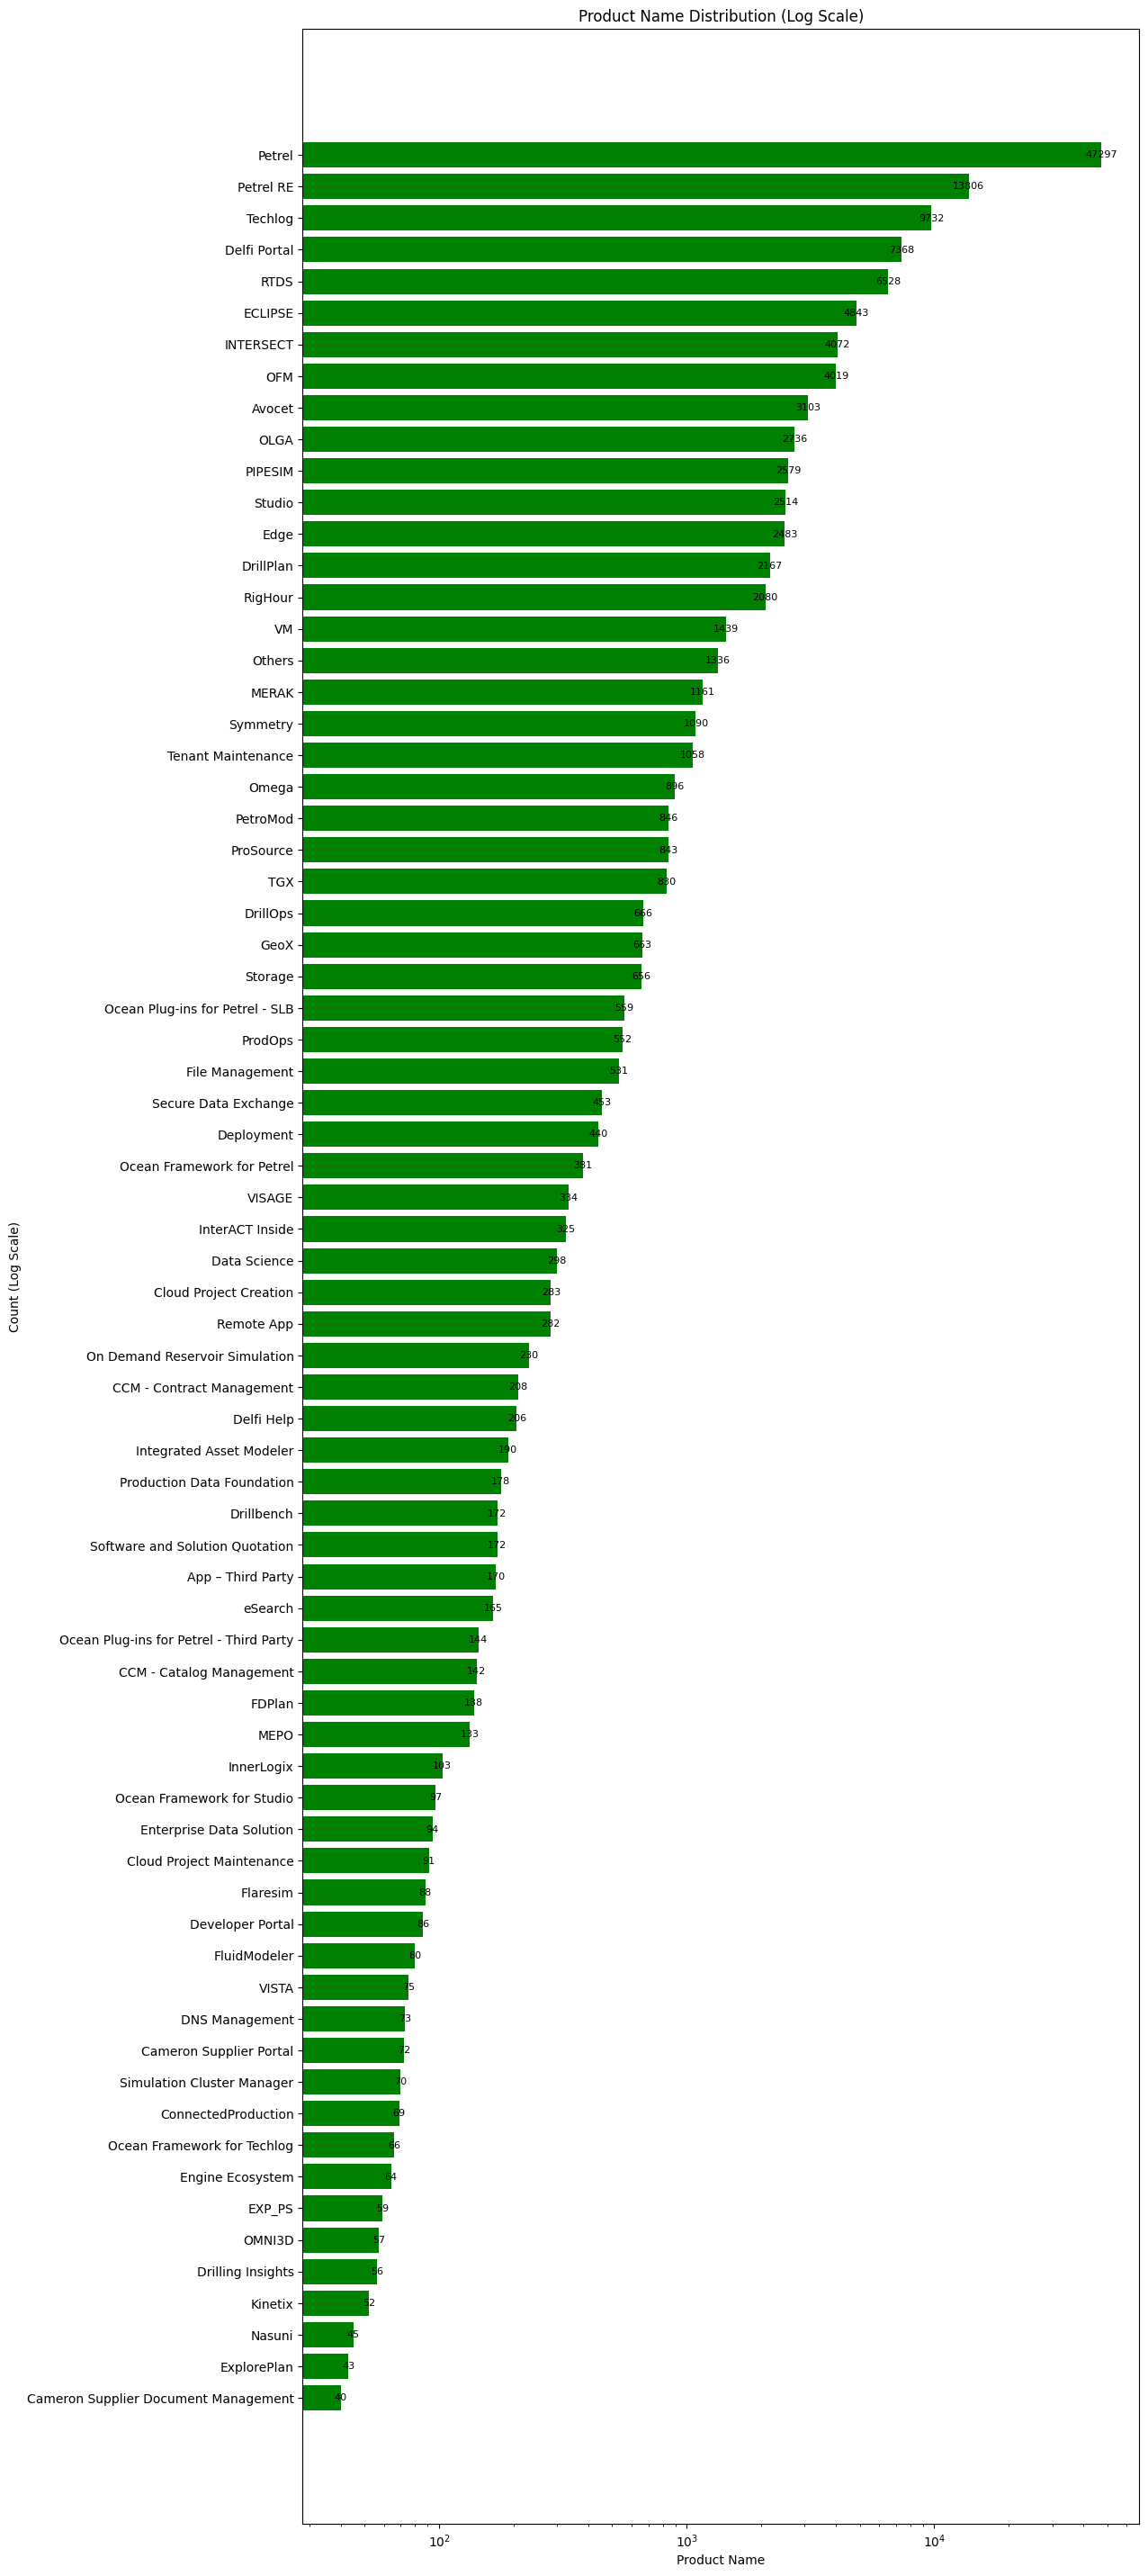

In [25]:
hist_by_labels(df_argumented, 'Product Name', top=None, log=True, horizontal=False)

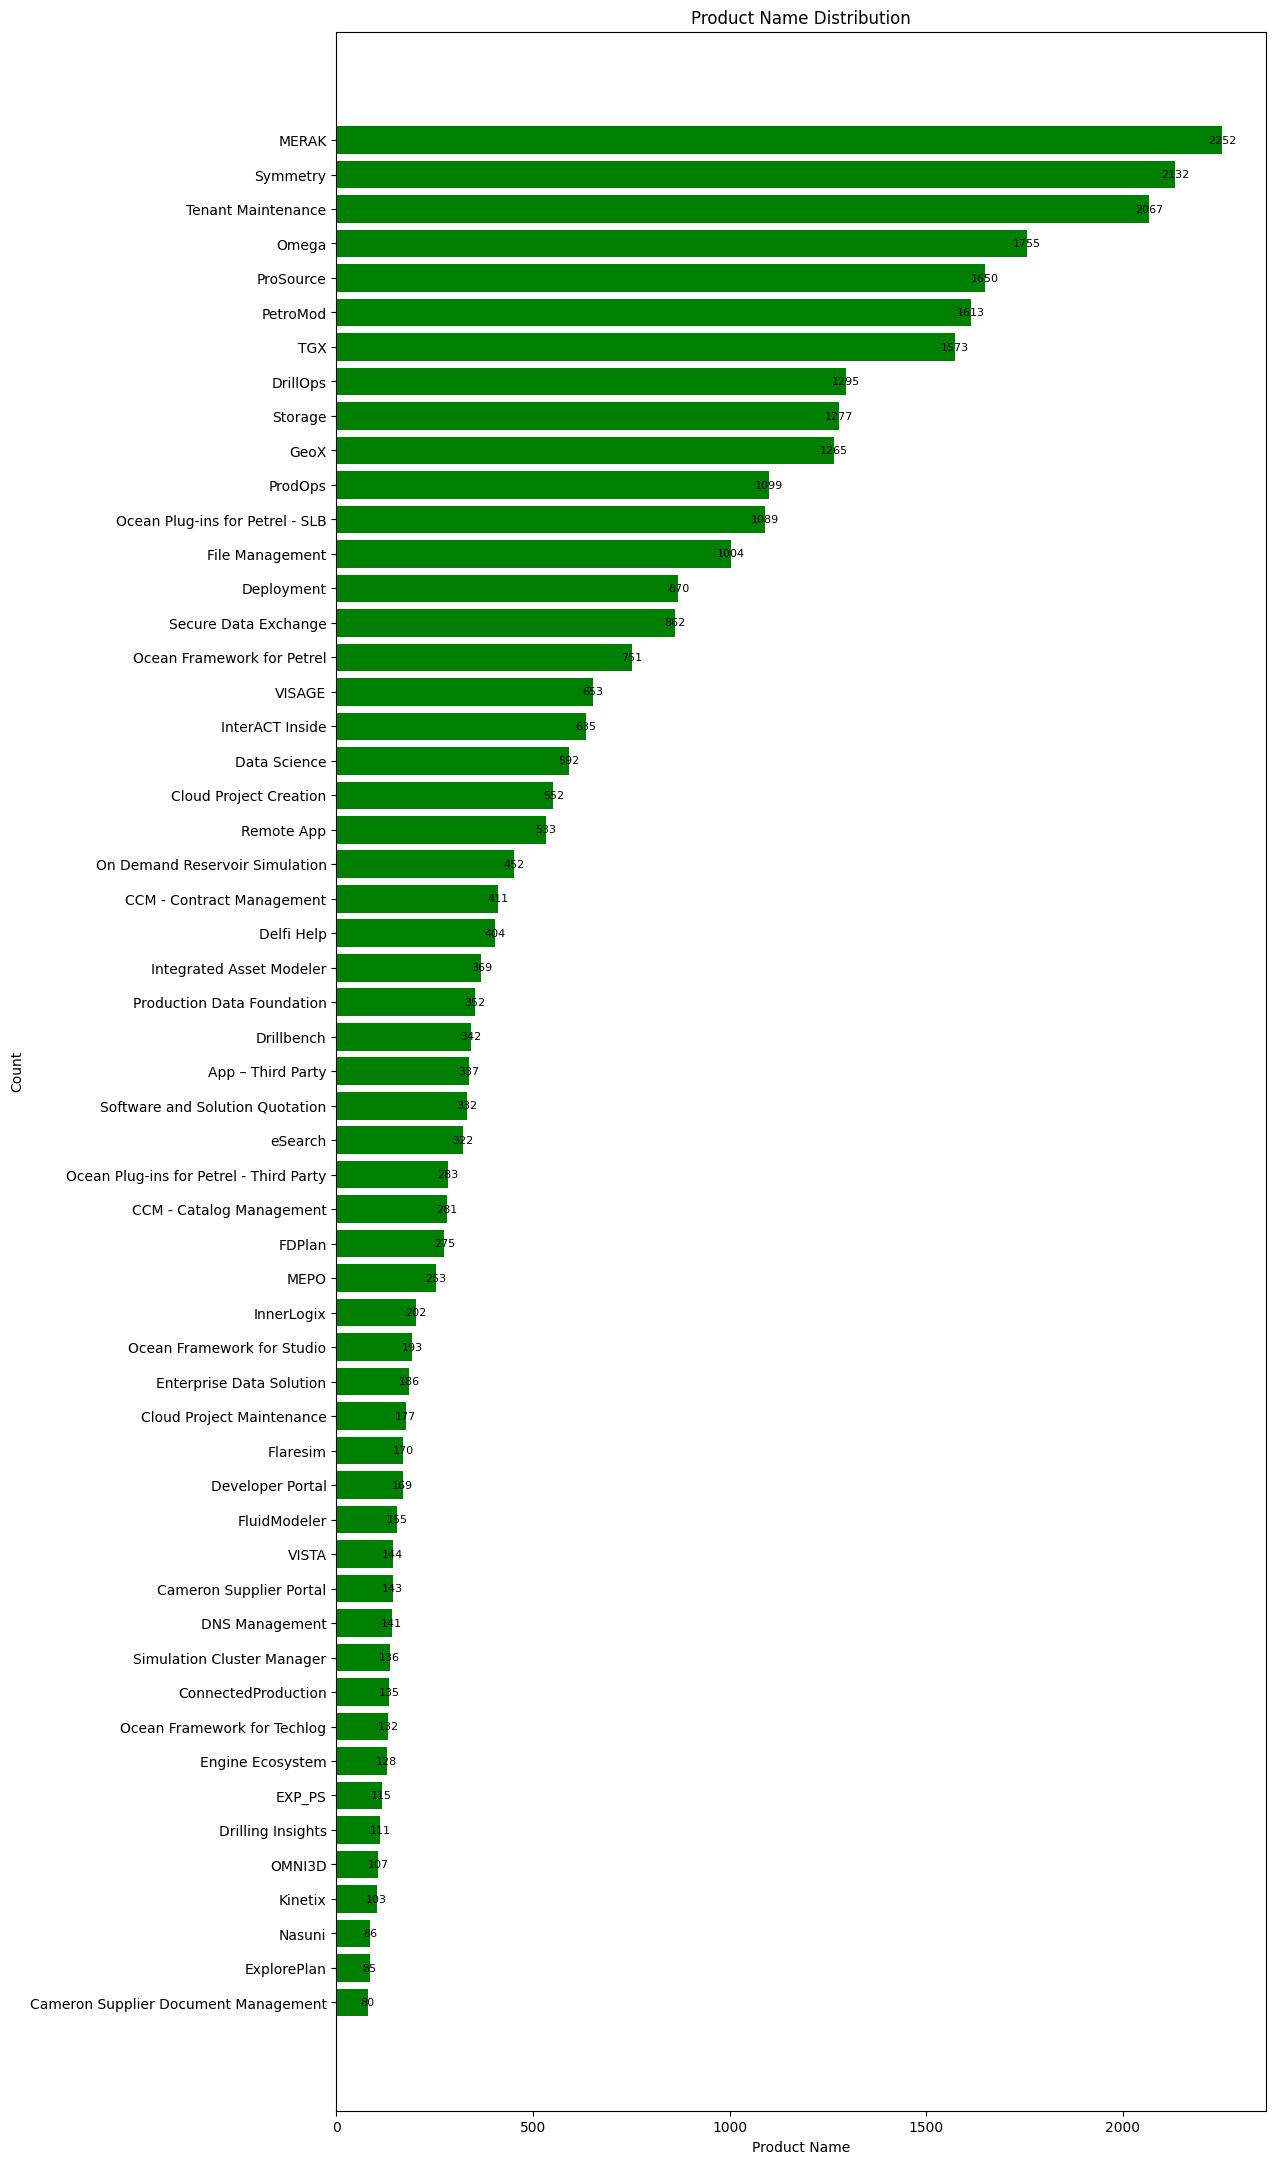

In [36]:
product_counts = df_argumented['Product Name'].value_counts()
top = 2400
# get the product names which have counts between top and bottom
product_minority_2400 = product_counts.index[product_counts < top]

mask_minority_2400 = df_argumented['Product Name'].isin(product_minority_2400)
df_minority_2400 = df_argumented[mask_minority_2400].copy()
hist_by_labels(df_minority_2400, 'Product Name', log=False, horizontal=False)

In [37]:
df_minority_2400.shape

(32830, 22)

In [39]:
intermediate_lang = 'ru'
df_minority_2400_arg = df_minority_2400.copy()

translated_titles = df_minority_2400_arg["Title_Translated"].tolist()

translated_titles = translate_array(
    translated_titles,
    src_lang='en',
    tar_lang=intermediate_lang,
    length_limit=1250)

translated_titles = translate_array(
    translated_titles,
    src_lang=intermediate_lang,
    tar_lang='fr',
    length_limit=1250)

translated_titles = translate_array(
    translated_titles,
    src_lang='fr',
    tar_lang='en',
    length_limit=2500)

# concatenate the df_minority_ru to df_cleaned
df_minority_2400_arg["Title_Translated"] = translated_titles

In [40]:
df_argumented = pd.concat([df_argumented, df_minority_2400_arg], ignore_index=True)
df_argumented.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)

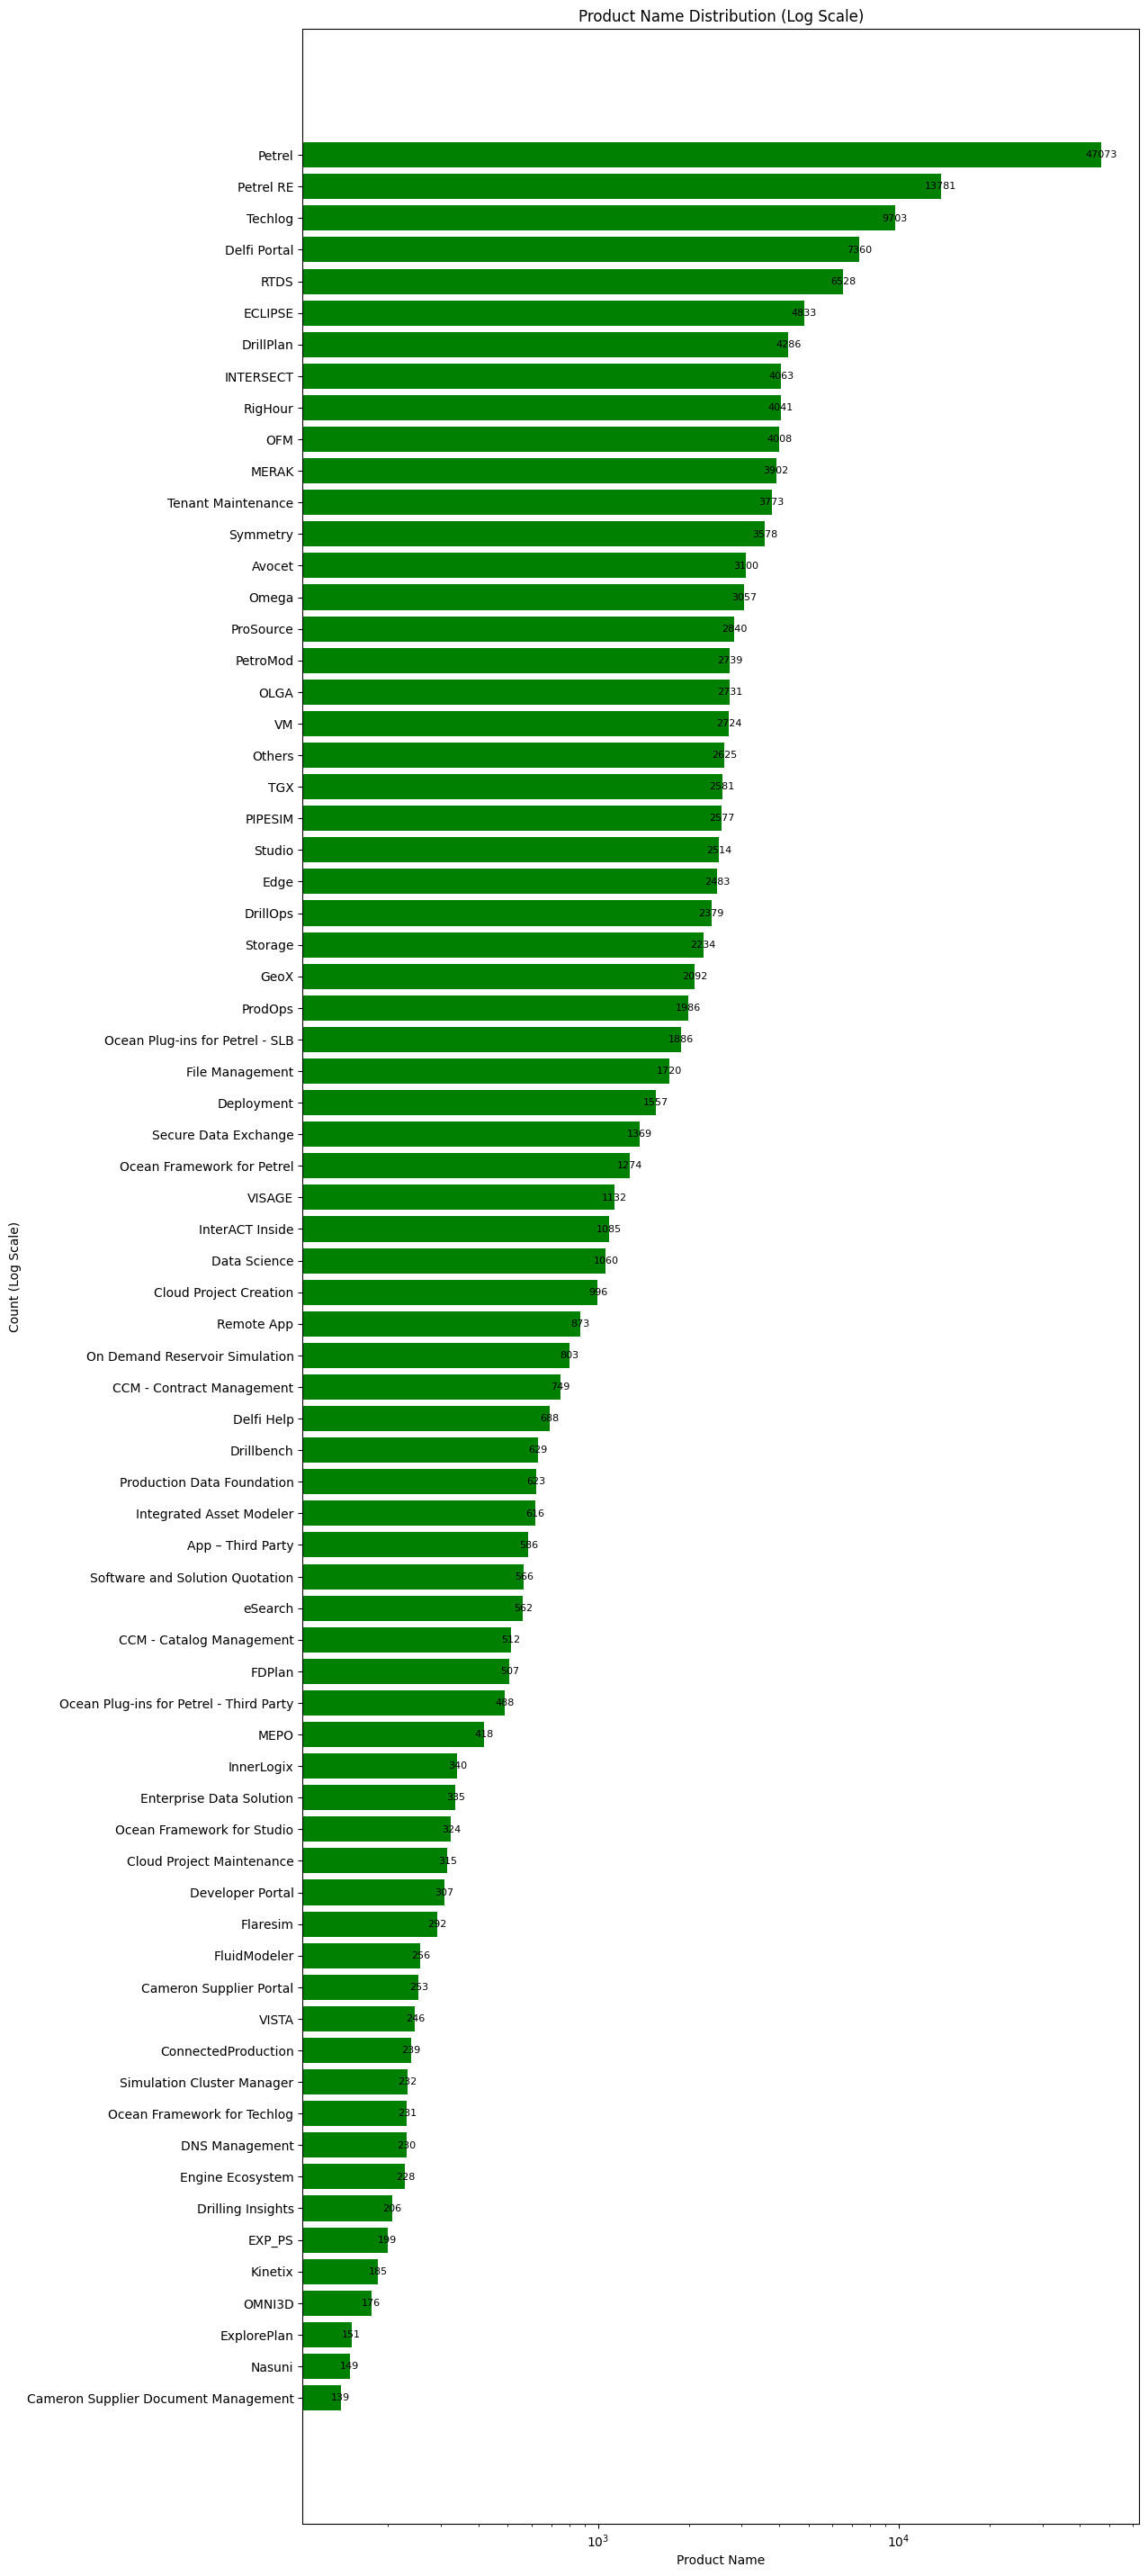

In [43]:
hist_by_labels(df_argumented, 'Product Name', top=None, log=True, horizontal=False)

In [44]:
df_argumented.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181323 entries, 0 to 190088
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             181323 non-null  object        
 1   Title                  181323 non-null  object        
 2   Created Time           181323 non-null  datetime64[ns]
 3   Customer Company       181175 non-null  object        
 4   Customer Country       181262 non-null  object        
 5   Priority               181323 non-null  object        
 6   Urgency                181323 non-null  object        
 7   Impact                 181323 non-null  object        
 8   Product Name           181323 non-null  object        
 9   Service Definition     181315 non-null  object        
 10  Service Desk Group     180305 non-null  object        
 11  Status                 181323 non-null  object        
 12  Closed Time            177527 non-null  datetime6

In [45]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_argumented.xlsx'

# Export the DataFrame to Excel
df_argumented.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Final Clean up

In [46]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_argumented.xlsx'

df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())
print(df_cleaned.info())
df_cleaned.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181323 entries, 0 to 181322
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             181323 non-null  object        
 1   Title                  181323 non-null  object        
 2   Created Time           181323 non-null  datetime64[ns]
 3   Customer Company       181175 non-null  object        
 4   Customer Country       181262 non-null  object        
 5   Priority               181323 non-null  object        
 6   Urgency                181323 non-null  object        
 7   Impact                 181323 non-null  object        
 8   Product Name           181323 non-null  object        
 9   Service Definition     181315 non-null  object        
 10  Service Desk Group     180305 non-null  object        
 11  Status                 181323 non-null  object        
 12  Closed Time            177527 non-null  date

,Request ID,Title,Created Time,Customer Company,Customer Country,Priority,Urgency,Impact,Product Name,Service Definition,...,Closed Time,Response Time (Min),Resolution Time (Min),Contracts Reference,Creation Source,Length,Language,Title_Processed,Title_Translated,Title_Cleaned
0,1705753,OFM Support,2022-12-14 06:29:13,AL-KHAFJI JOINT OPERATIONS (AGOC/KGOC),NaN,P4 Low,This issue disrupts my work,Single user,OFM,Software Support,...,2022-12-29 06:30:58,0.0000,0.7150,Standard-Software-Maintenance-Contract,Agent Created Ticket,11,en,OFM Support,OFM Support,NaN
1,1130253,Rerun workflow and Create workflow option not ...,2022-01-04 21:52:01,GROUPEMENT REGGANE,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel RE,Software Support,...,2022-01-10 03:16:58,66.0677,0.0000,Standard-Software-Maintenance-Contract,Support Portal,55,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,NaN
2,1130330,[Ext] TR- Registration Completion Notice,2022-01-05 08:07:22,SH - PED,ALGERIA,P4 Low,This issue disrupts my work,Single user,ECLIPSE,Software Support,...,2022-01-21 08:27:25,37.6989,1402.1556,Standard-Software-Maintenance-Contract,Email,37,en,Ext TR Registration Completion Notice,Ext TR Registration Completion Notice,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,2022-01-05 14:29:47,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Other Requests,...,2022-01-05 14:32:14,0.0000,3.2456,Standard-Software-Maintenance-Contract,Agent Created Ticket,31,en,SH PED Patch Log for pro Source,SH PED Patch Log for pro Source,NaN
4,1131191,SH-PED: issue with ProSource services,2022-01-05 14:34:47,SH - PED,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,ProSource,Software Support,...,2022-01-05 14:36:32,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,37,en,SH PED issue with Pro Source services,SH PED issue with Pro Source services,NaN
5,1131193,SH-PED: ProSource new License file,2022-01-05 14:38:53,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Software Support,...,2022-01-05 14:40:15,1.8040,1.8206,Standard-Software-Maintenance-Contract,Agent Created Ticket,34,en,SH PED Pro Source new License file,SH PED Pro Source new License file,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,2022-01-08 09:14:32,SH - DP - HMD,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,Delfi Portal,Software Support,...,2022-01-24 18:17:23,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,40,en,Schlumberger Licensing Tool not starting,Schlumberger Licensing Tool not starting,NaN
7,1135119,Production by zone/segment,2022-01-09 21:26:38,ALNAFT,ALGERIA,P3 Medium,This issue partially blocks my work,Single user,Petrel RE,Software Support,...,2022-01-25 07:27:22,0.0000,0.0000,Standard-Software-Maintenance-Contract,Support Portal,26,en,Production by zone segment,Production by zone segment,NaN
8,1136751,data exchanger with client,2022-01-10 09:47:01,SONATRACH DIVISION PRODUCTION,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel,Software Support,...,2022-01-18 10:07:20,0.1846,4234.9140,Standard-Software-Maintenance-Contract,Agent Created Ticket,26,en,data exchanger with client,data exchanger with client,NaN
9,1140517,"Error: Unable to start external queue, but run...",2022-01-12 16:03:12,GROUPEMENT REGGANE,ALGERIA,P3 Medium,I am blocked from doing my job,Single user,Petrel RE,Software Support,...,2022-01-20 15:52:23,208.3179,6875.1180,Standard-Software-Maintenance-Contract,Support Portal,56,en,Error Unable to start external queue but runni...,Error Unable to start external queue but runni...,NaN


In [47]:
df_cleaned.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Set the number of rows to process
num = df_cleaned['Title_Translated'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Title_Cleaned'] = final_clean_up(df_cleaned.at[index, 'Title_Translated'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Cleaned'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

print(df_cleaned.info())

Processing Rows: 100%|█████████▉| 181057/181323 [00:28<00:00, 6441.94 row/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181323 entries, 0 to 181322
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        181323 non-null  object
 1   Title             181323 non-null  object
 2   Product Name      181323 non-null  object
 3   Length            181323 non-null  int64 
 4   Language          181323 non-null  object
 5   Title_Processed   181323 non-null  object
 6   Title_Translated  181323 non-null  object
 7   Title_Cleaned     181057 non-null  object
dtypes: int64(1), object(7)
memory usage: 11.1+ MB
None


In [48]:
# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Title_Cleaned'], inplace=True)
df_cleaned.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Title_Cleaned'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Title_Cleaned'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))

<class 'pandas.core.frame.DataFrame'>
Index: 163822 entries, 7 to 181321
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        163822 non-null  object
 1   Title             163822 non-null  object
 2   Product Name      163822 non-null  object
 3   Length            163822 non-null  int64 
 4   Language          163822 non-null  object
 5   Title_Processed   163822 non-null  object
 6   Title_Translated  163822 non-null  object
 7   Title_Cleaned     163822 non-null  object
dtypes: int64(1), object(7)
memory usage: 11.2+ MB
None
157178
<class 'pandas.core.frame.DataFrame'>
Index: 157178 entries, 7 to 181321
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        157178 non-null  object
 1   Title             157178 non-null  object
 2   Product Name      157178 non-null  object
 3   Length           

In [49]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'

# Export the DataFrame to Excel
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Training

## Prepare Data for Modeling

### Load Cleaned Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157178 entries, 0 to 157177
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        157178 non-null  int64 
 1   Title             157178 non-null  object
 2   Product Name      157178 non-null  object
 3   Length            157178 non-null  int64 
 4   Language          157178 non-null  object
 5   Title_Processed   157178 non-null  object
 6   Title_Translated  157178 non-null  object
 7   Title_Cleaned     157178 non-null  object
dtypes: int64(2), object(6)
memory usage: 9.6+ MB
None


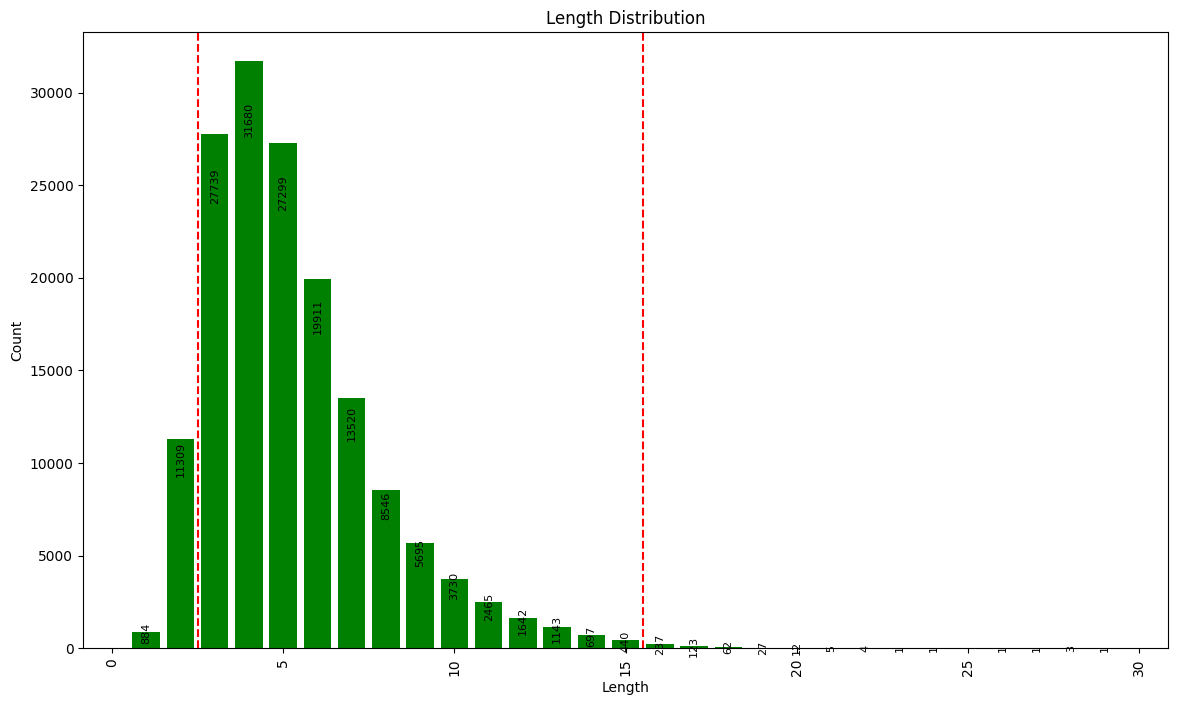

In [50]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned = pd.read_excel(excel_file)
print(df_cleaned.info())
hist_by_labels(df_cleaned, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

### Remove short Titles

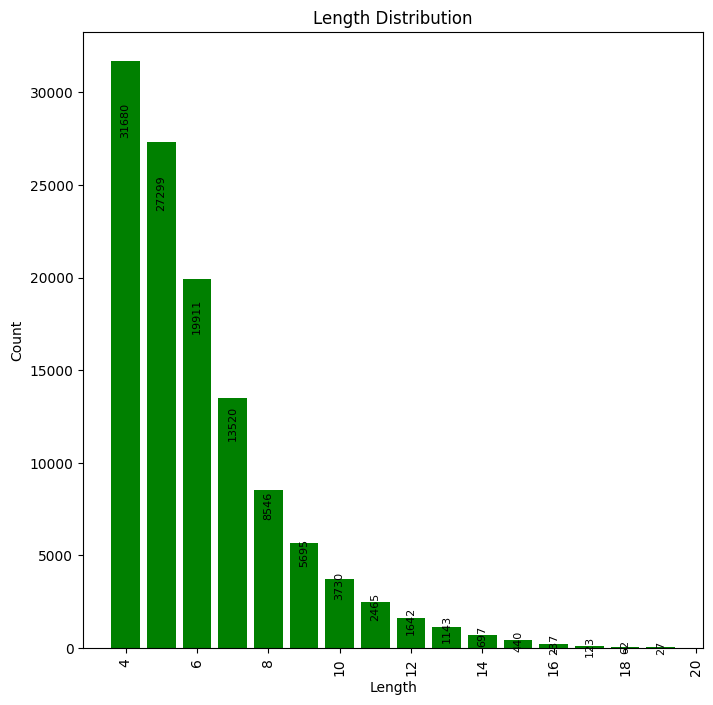

In [51]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_cleaned['Length'] > 3) & (df_cleaned['Length'] < 20)
df_cleaned = df_cleaned[mask]
hist_by_labels(df_cleaned, 'Length', horizontal=True)

### Combine the long tail into Others

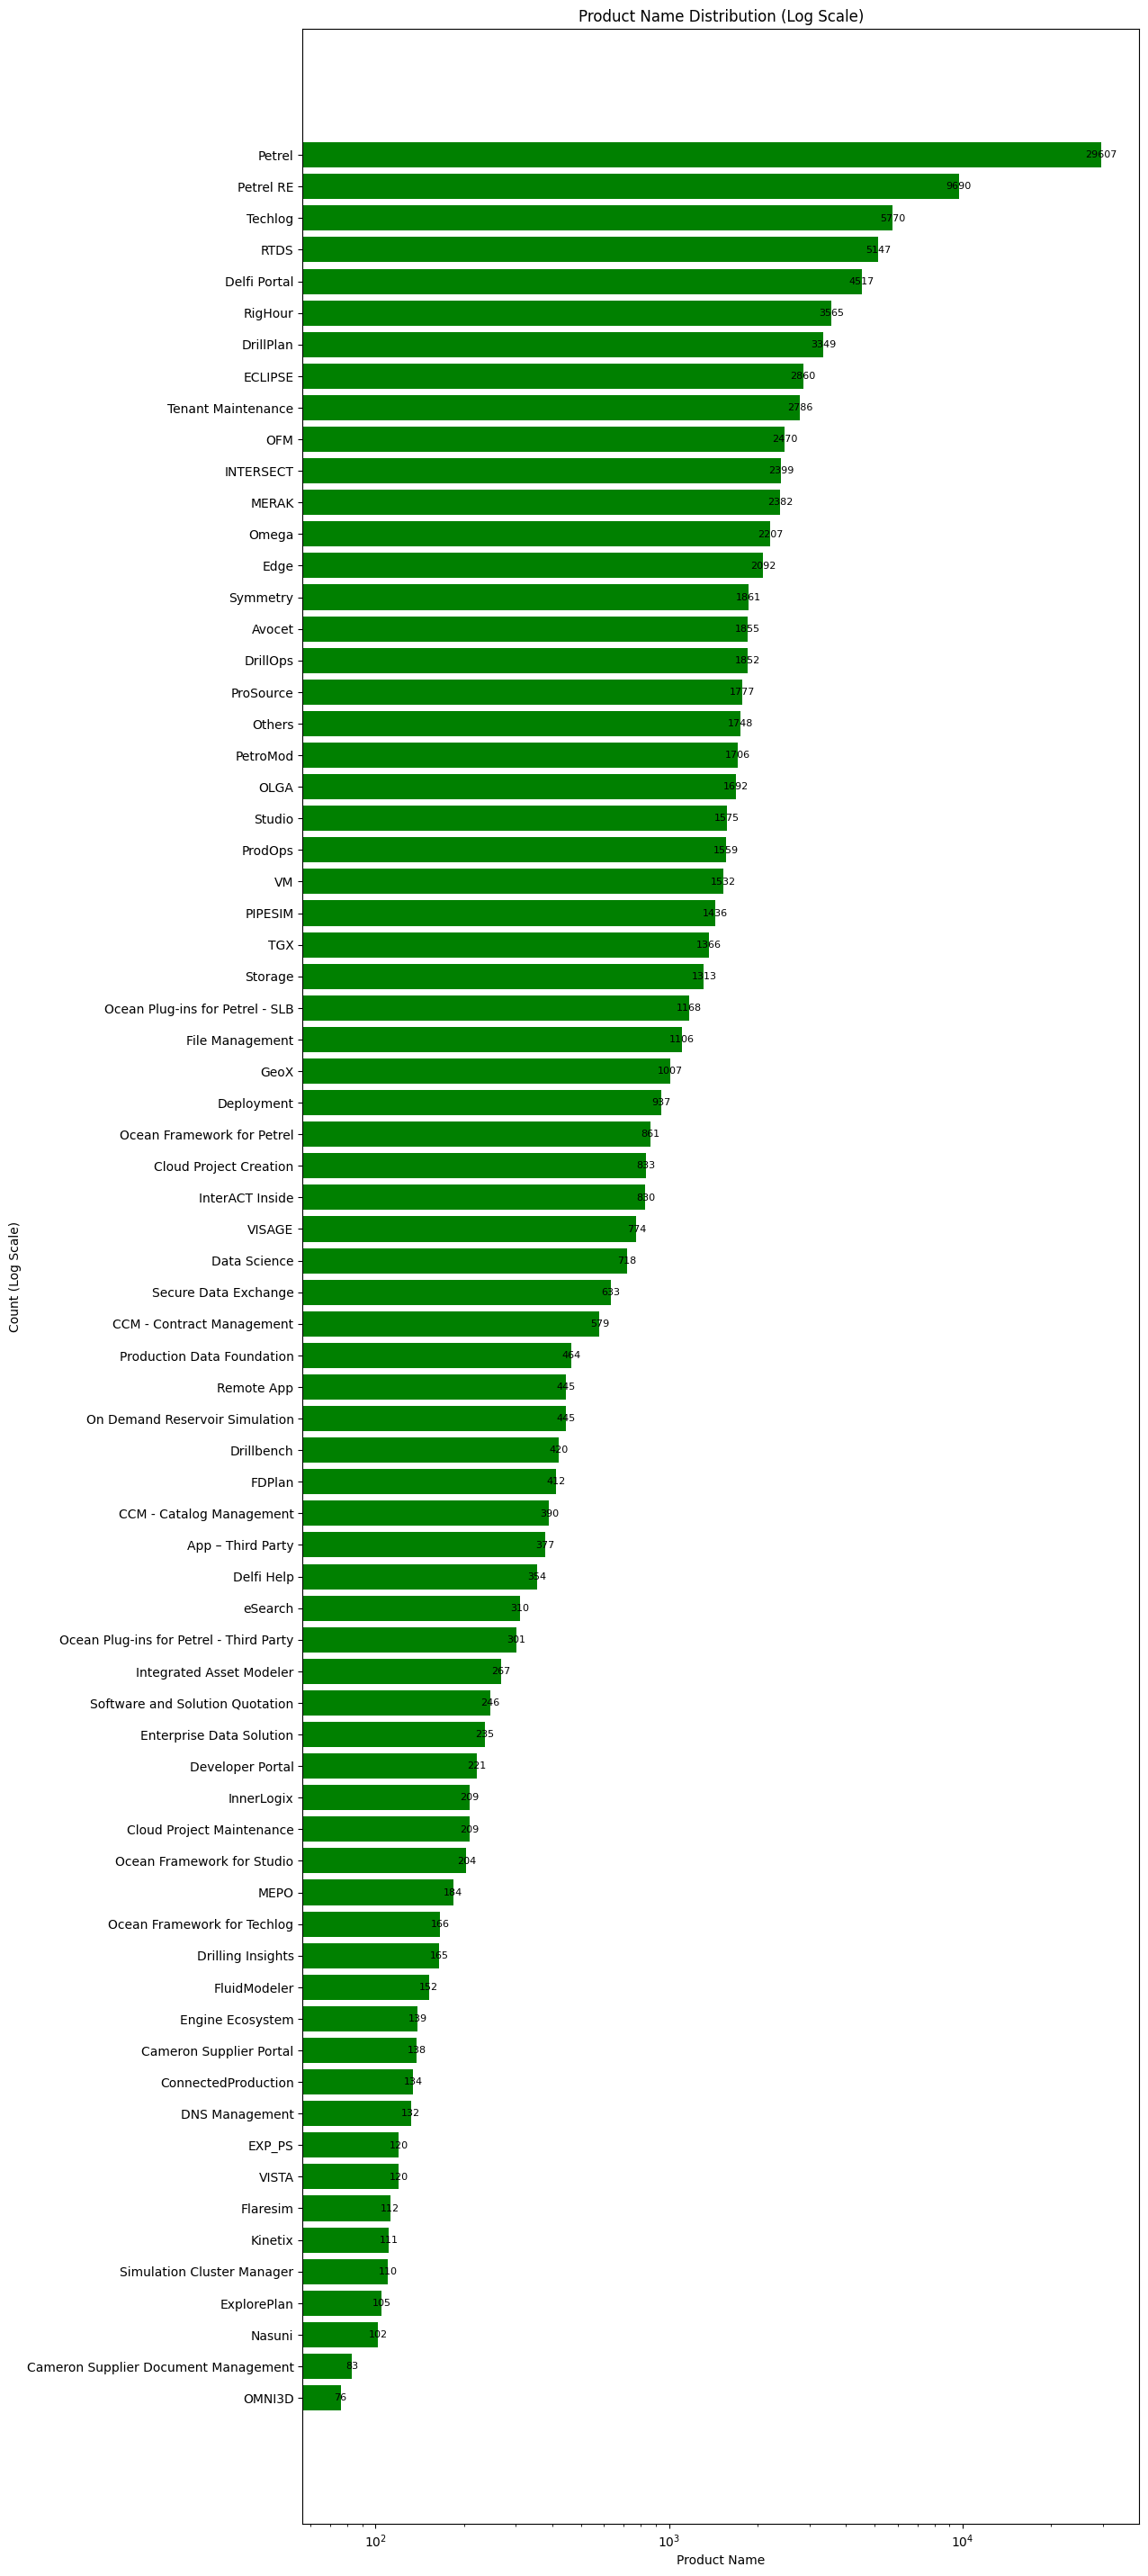

In [53]:
hist_by_labels(df_cleaned, 'Product Name', top=None, log=True, horizontal=False)

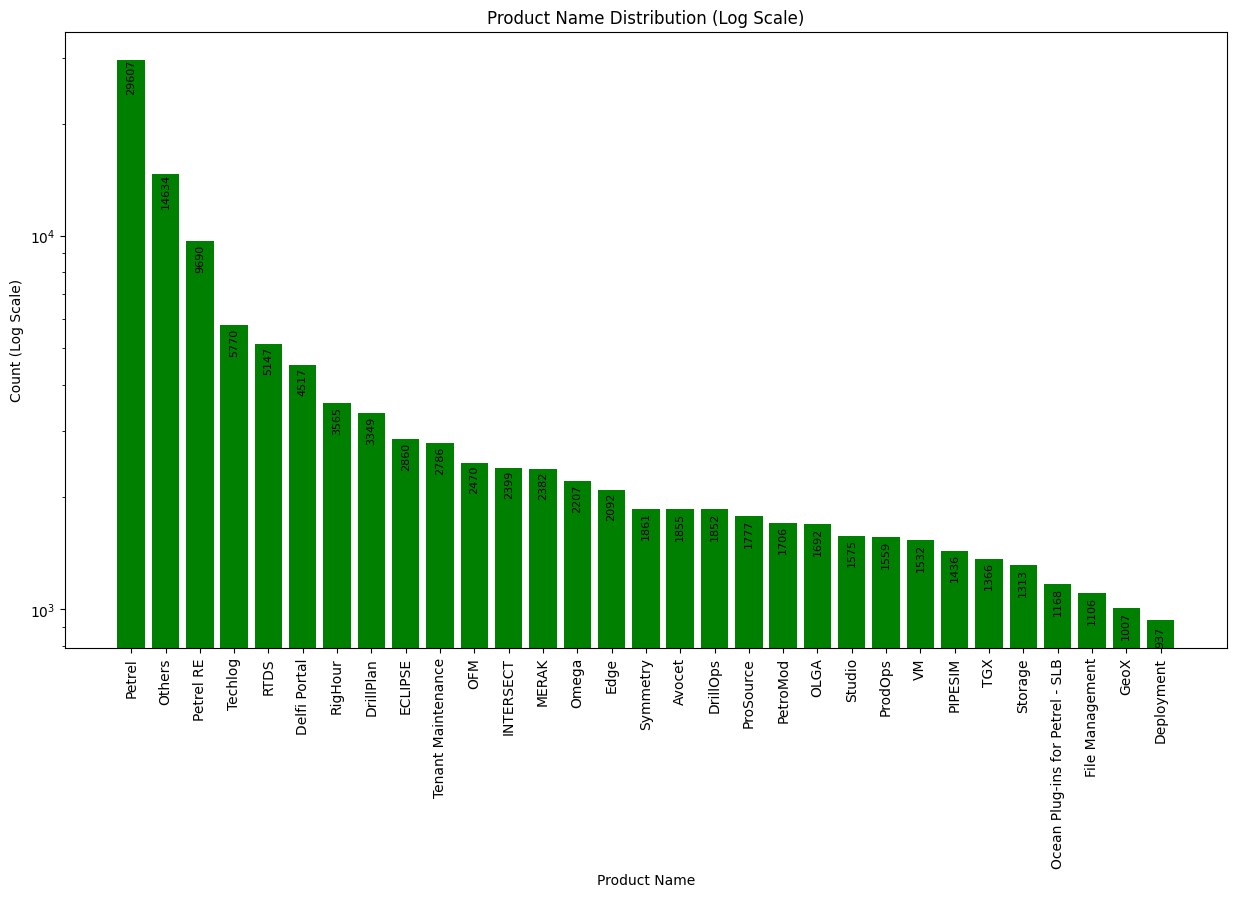

In [54]:
# Keep the top 50 products and combine the rest into 'Others'
product_counts = df_cleaned['Product Name'].value_counts()
cutoff = 900
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_cleaned['Product Name'].isin(product_others)
df_cleaned.loc[mask_others,'Product Name']='Others'
hist_by_labels(df_cleaned, 'Product Name', log=True)

### Train/Test Split

<class 'pandas.core.frame.DataFrame'>
Index: 61899 entries, 28678 to 135185
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        61899 non-null  int64 
 1   Title             61899 non-null  object
 2   Product Name      61899 non-null  object
 3   Length            61899 non-null  int64 
 4   Language          61899 non-null  object
 5   Title_Processed   61899 non-null  object
 6   Title_Translated  61899 non-null  object
 7   Title_Cleaned     61899 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 55318 entries, 10 to 138782
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        55318 non-null  int64 
 1   Title             55318 non-null  object
 2   Product Name      55318 non-null  object
 3   Length            55318 non-null  int

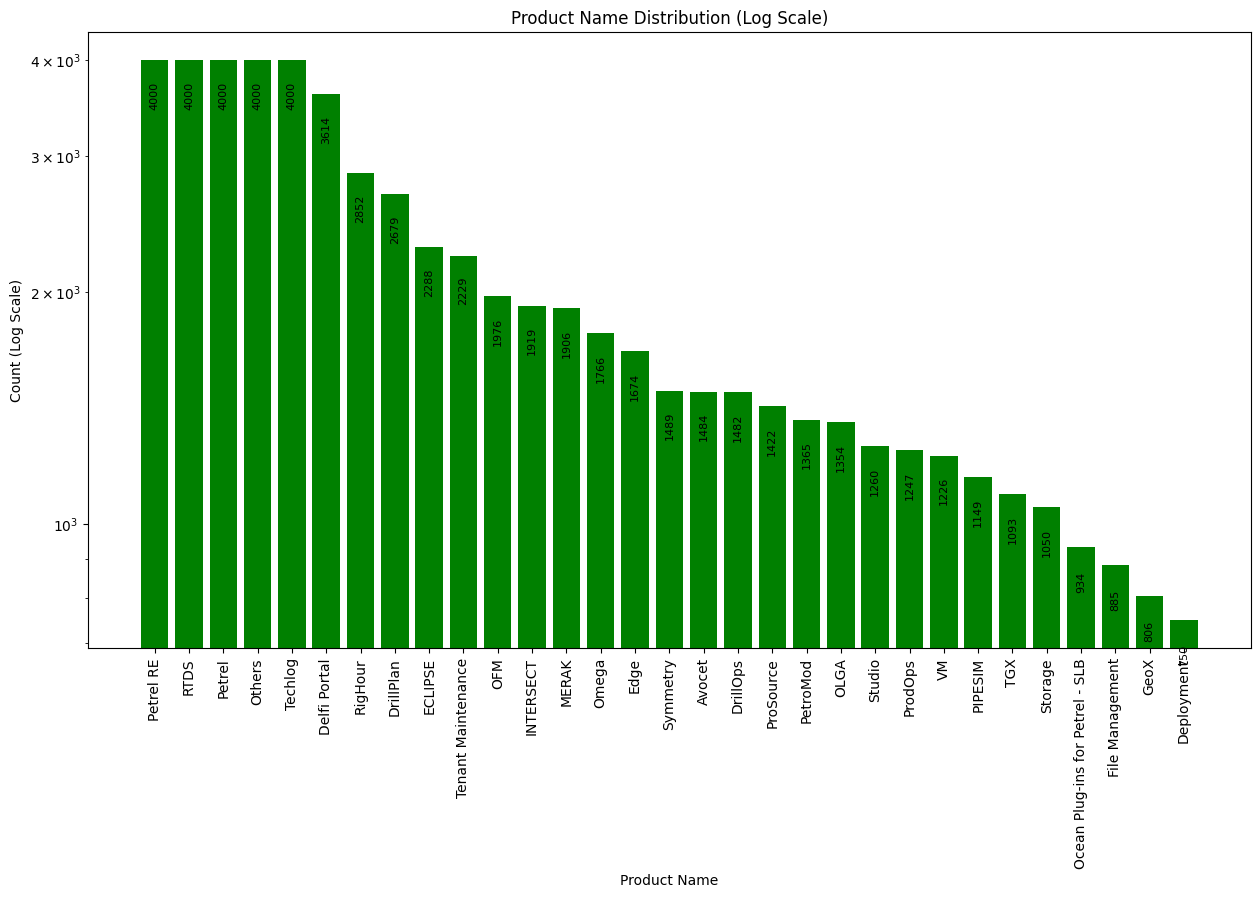

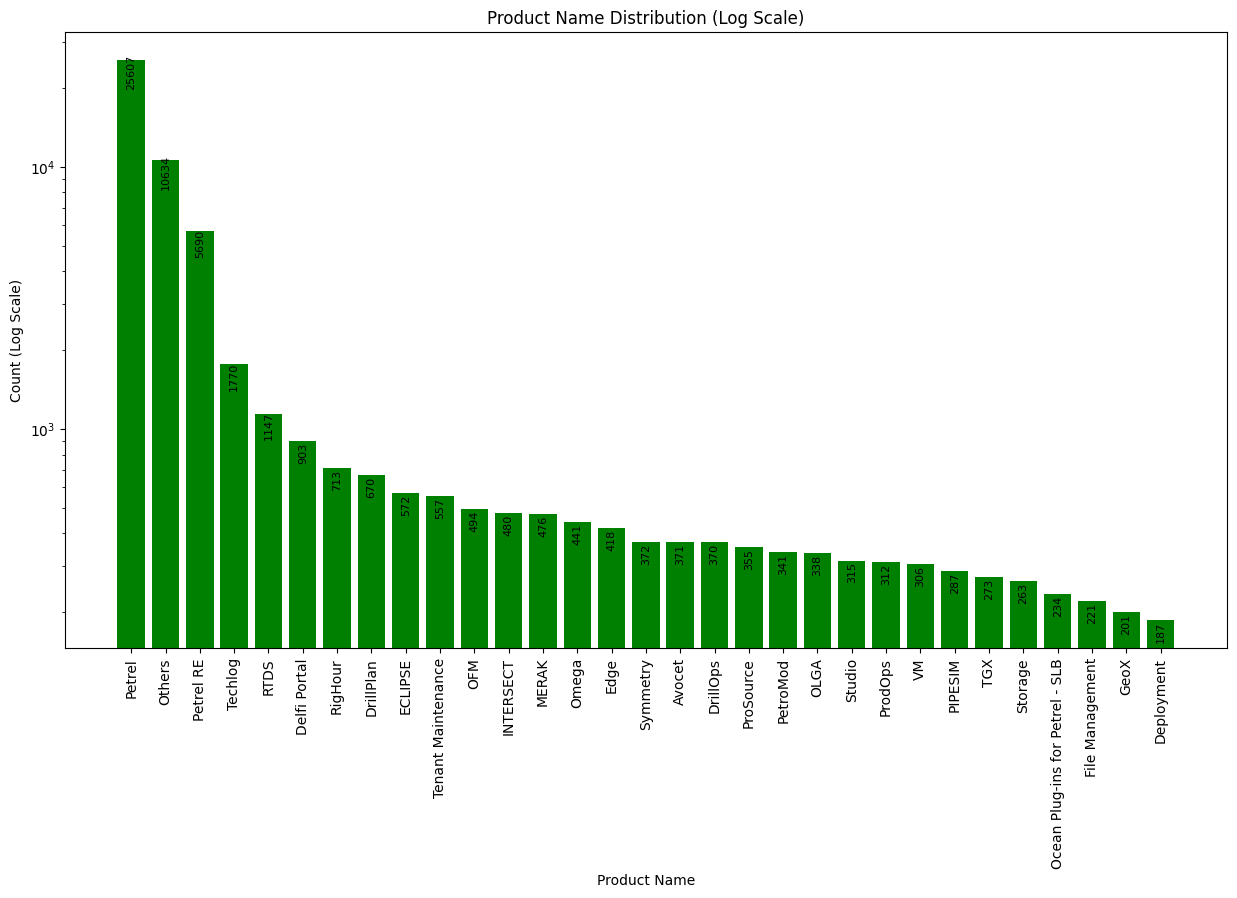

In [55]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
df_cleaned_balanced = pd.DataFrame()
df_cleaned_test = pd.DataFrame()
for product in df_cleaned['Product Name'].unique():
    df_product = df_cleaned[df_cleaned['Product Name'] == product]
    if df_product.shape[0] > 5000:
        df_product_balanced = df_product.sample(4000).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])
    else:
        df_product_balanced = df_product.sample(frac=0.8).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])

print(df_cleaned_balanced.info())
print(df_cleaned_test.info())

hist_by_labels(df_cleaned_balanced, 'Product Name', log=True)
hist_by_labels(df_cleaned_test, 'Product Name', log=True)

In [56]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = df_cleaned['Title_Cleaned']
vectorizer = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer.fit(X)

X_train = df_cleaned_balanced['Title_Cleaned']
X_train_encoded = vectorizer.transform(X_train)
y_train = df_cleaned_balanced['Product Name']

X_test = df_cleaned_test['Title_Cleaned']
X_test_encoded = vectorizer.transform(X_test)
y_test = df_cleaned_test['Product Name']

## Model Baseline - Cross Validation

In [57]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [58]:
models = {
    'MultinomialNB': MultinomialNB(),
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'SVC rbf': SVC(kernel='rbf'),
    # 'SVC linear': SVC(kernel='linear'),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'XGBClassifier': xgb.XGBClassifier()
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded, # please provide the features after preprocessing
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.7464 by MultinomialNB.
Average score: 0.7838 by SGDClassifier.
Average score: 0.7868 by LogisticRegression.


# Hpyerparameter Tuning

## SGC Classifier

In [61]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=200, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-19 17:13:33,966] A new study created in memory with name: no-name-63f0367a-aa89-4e78-8941-0b7721917b03


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-10-19 17:13:40,033] Trial 1 finished with value: 0.7554403733144921 and parameters: {'loss': 'modified_huber', 'alpha': 0.00222134594988762, 'penalty': 'l2'}. Best is trial 1 with value: 0.7554403733144921.
[I 2023-10-19 17:13:40,319] Trial 8 finished with value: 0.7430169103154399 and parameters: {'loss': 'modified_huber', 'alpha': 0.003419135582006085, 'penalty': 'l2'}. Best is trial 1 with value: 0.7554403733144921.
[I 2023-10-19 17:13:43,110] Trial 5 finished with value: 0.3395326626037295 and parameters: {'loss': 'log_loss', 'alpha': 44.238807970622226, 'penalty': 'l2'}. Best is trial 1 with value: 0.7554403733144921.
[I 2023-10-19 17:13:43,654] Trial 0 finished with value: 0.3579344011256752 and parameters: {'loss': 'modified_huber', 'alpha': 6.31912572655899, 'penalty': 'l2'}. Best is trial 1 with value: 0.7554403733144921.
[I 2023-10-19 17:13:43,712] Trial 6 finished with value: 0.5082796898859799 and parameters: {'loss': 'modified_huber', 'alpha': 0.0064775298240049095

                                 precision    recall  f1-score   support

                         Avocet      0.536     0.803     0.643       371
                   Delfi Portal      0.220     0.641     0.327       903
                     Deployment      0.542     0.615     0.576       187
                       DrillOps      0.784     0.873     0.826       370
                      DrillPlan      0.529     0.887     0.663       670
                        ECLIPSE      0.276     0.598     0.377       572
                           Edge      0.954     0.983     0.968       418
                File Management      0.495     0.670     0.569       221
                           GeoX      0.651     0.871     0.745       201
                      INTERSECT      0.300     0.673     0.415       480
                          MERAK      0.752     0.937     0.834       476
                            OFM      0.810     0.844     0.827       494
                           OLGA      0.808     0.8

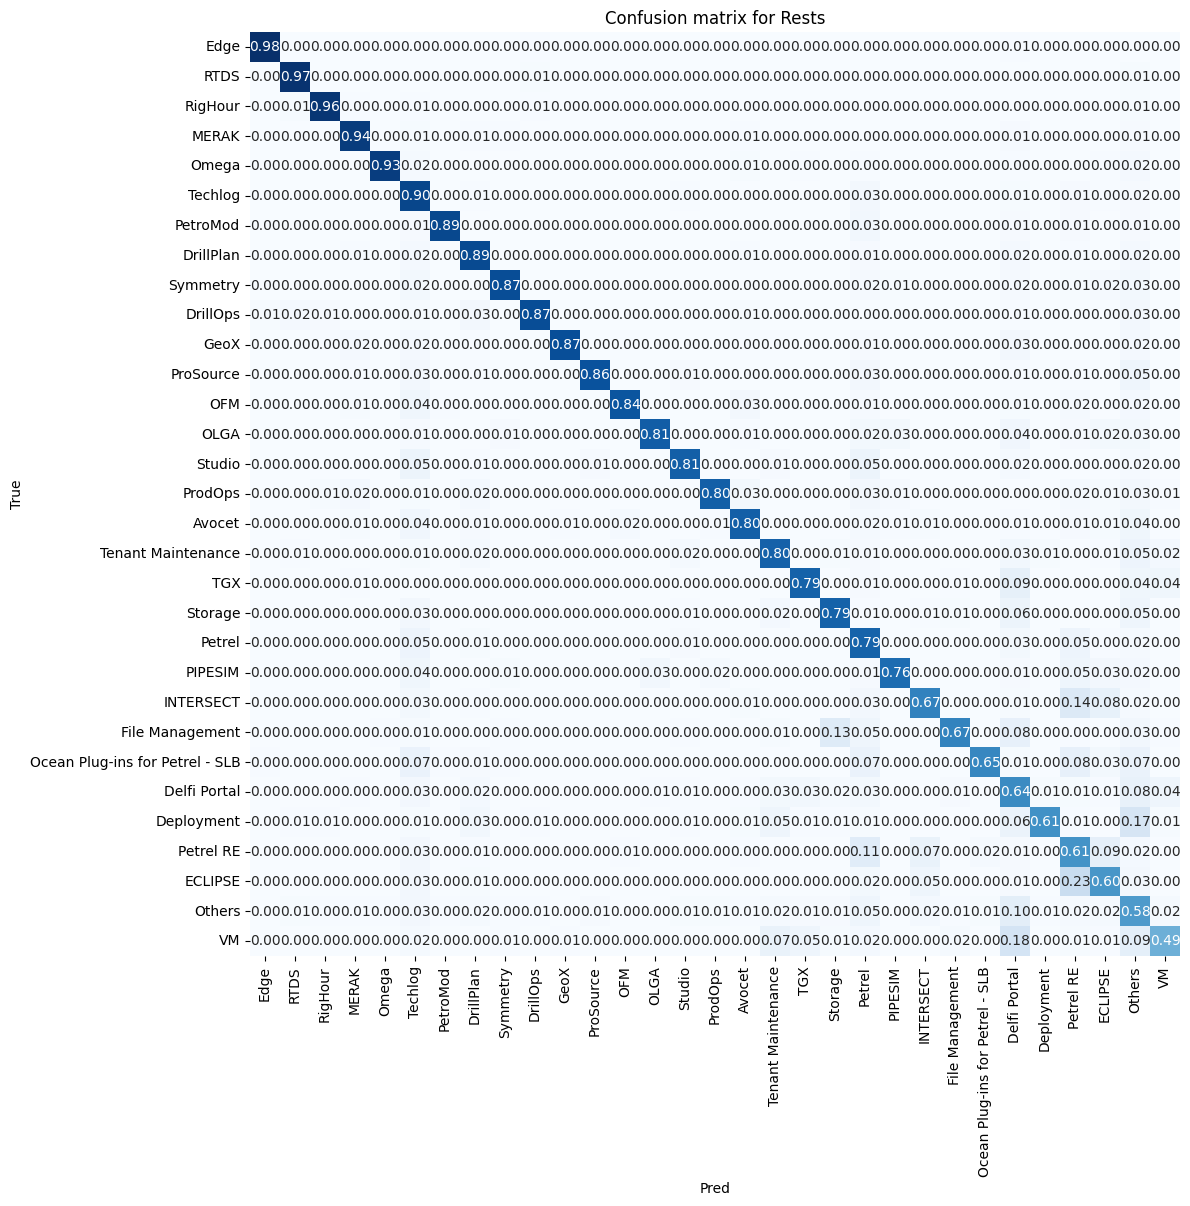

Accuracy of top 1 prediction is 0.739.
Accuracy of top 3 prediction is 0.916.
Accuracy of top 5 prediction is 0.941.


In [62]:
# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [63]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))


## Logistic Classification

Accuracy: 0.737
                                 precision    recall  f1-score   support

                         Avocet      0.539     0.790     0.640       371
                   Delfi Portal      0.221     0.649     0.330       903
                     Deployment      0.508     0.701     0.589       187
                       DrillOps      0.788     0.914     0.846       370
                      DrillPlan      0.526     0.879     0.658       670
                        ECLIPSE      0.262     0.601     0.365       572
                           Edge      0.981     0.967     0.973       418
                File Management      0.482     0.778     0.595       221
                           GeoX      0.685     0.856     0.761       201
                      INTERSECT      0.303     0.648     0.413       480
                          MERAK      0.797     0.941     0.863       476
                            OFM      0.792     0.868     0.828       494
                           OLGA   

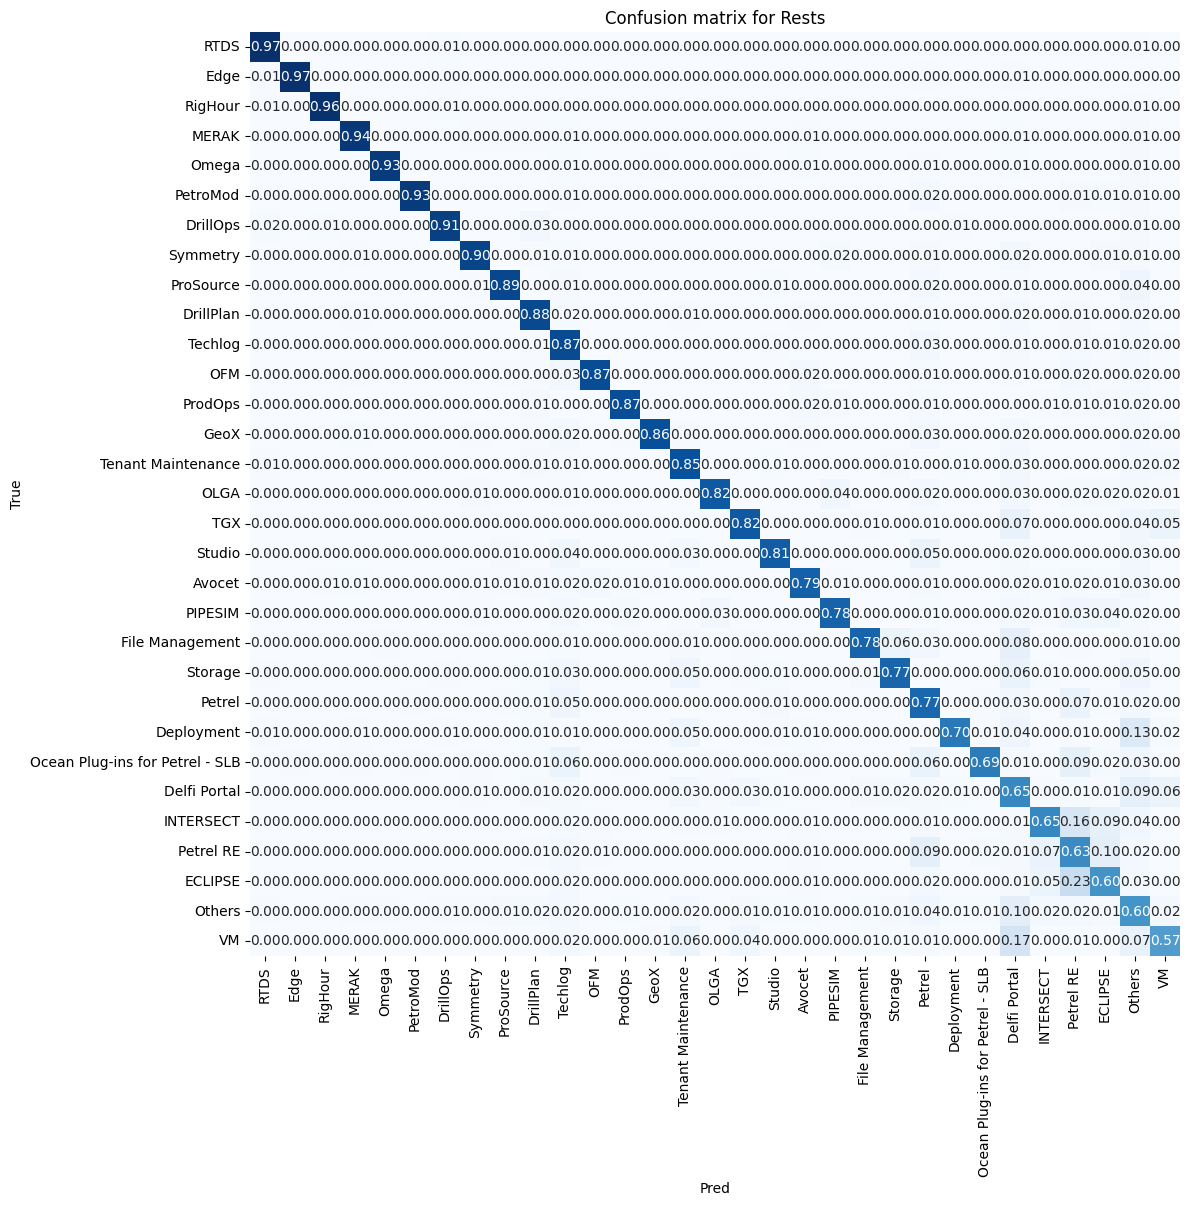

Accuracy of top 1 prediction is 0.737.
Accuracy of top 3 prediction is 0.927.
Accuracy of top 5 prediction is 0.965.


In [64]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_logReg = LogisticRegression(
    max_iter=5000,
    # class_weight= weights
)
model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [65]:
# export the model
import pickle
pickle.dump(model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [66]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=300, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-19 17:23:15,147] A new study created in memory with name: no-name-d6d61100-2d00-4b59-bb5a-68e086b134f9


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-10-19 17:23:19,013] Trial 0 finished with value: 0.7314496304844791 and parameters: {'alpha': 3.468322087922796e-06, 'fit_prior': False}. Best is trial 0 with value: 0.7314496304844791.
[I 2023-10-19 17:23:19,545] Trial 3 finished with value: 0.6848737471780144 and parameters: {'alpha': 5.3362421208029, 'fit_prior': True}. Best is trial 0 with value: 0.7314496304844791.
[I 2023-10-19 17:23:19,726] Trial 5 finished with value: 0.746748752805999 and parameters: {'alpha': 0.0013552570335984638, 'fit_prior': True}. Best is trial 5 with value: 0.746748752805999.
[I 2023-10-19 17:23:19,734] Trial 6 finished with value: 0.6418036016752013 and parameters: {'alpha': 46.33671292452509, 'fit_prior': False}. Best is trial 5 with value: 0.746748752805999.
[I 2023-10-19 17:23:19,744] Trial 2 finished with value: 0.7601415459319883 and parameters: {'alpha': 0.1142443847800606, 'fit_prior': True}. Best is trial 2 with value: 0.7601415459319883.
[I 2023-10-19 17:23:19,788] Trial 9 finished with

Accuracy: 0.689
                                 precision    recall  f1-score   support

                         Avocet      0.498     0.803     0.615       371
                   Delfi Portal      0.204     0.605     0.305       903
                     Deployment      0.288     0.684     0.406       187
                       DrillOps      0.623     0.916     0.742       370
                      DrillPlan      0.480     0.887     0.623       670
                        ECLIPSE      0.233     0.551     0.327       572
                           Edge      0.890     0.971     0.929       418
                File Management      0.280     0.792     0.414       221
                           GeoX      0.583     0.801     0.675       201
                      INTERSECT      0.243     0.621     0.350       480
                          MERAK      0.710     0.941     0.809       476
                            OFM      0.575     0.834     0.680       494
                           OLGA   

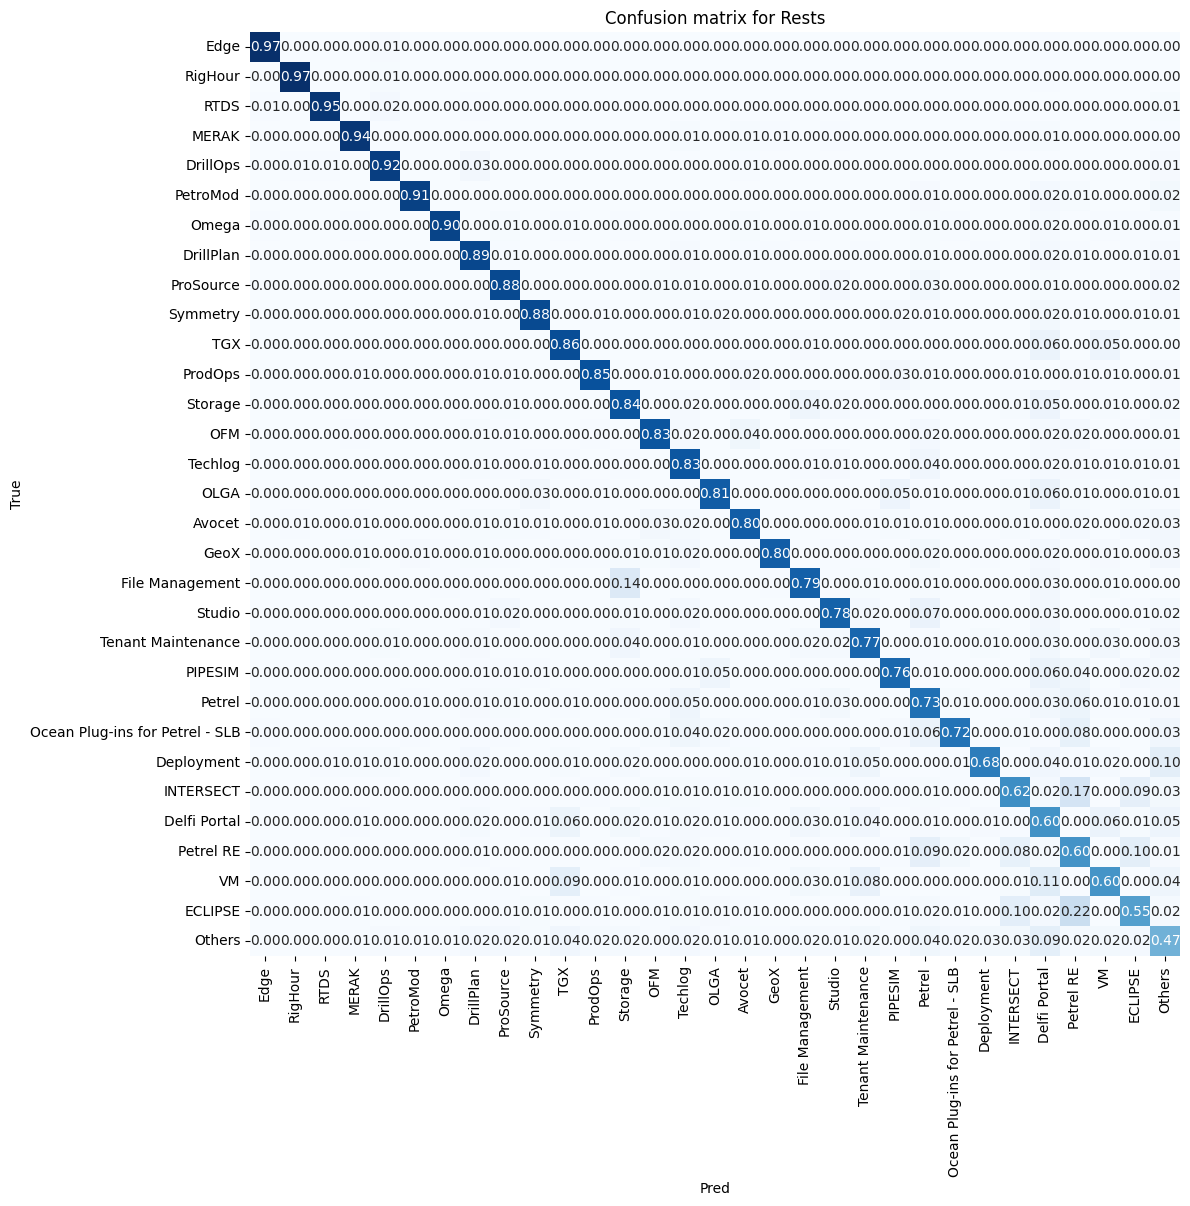

Accuracy of top 1 prediction is 0.689.
Accuracy of top 3 prediction is 0.889.
Accuracy of top 5 prediction is 0.943.


In [67]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer, X_test, y_test, pre_processed=True)

In [68]:
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))